# Spacy Entity Recognition

In [1]:
# %pip install awswrangler
# !pip install spacy && python -m spacy download pt_core_news_sm

In [2]:
import os 
import sys
import json
import boto3 
import spacy
import random
import numpy as np
import pandas as pd
import awswrangler as wr
from spacy.tokens import DocBin
import matplotlib.pyplot as plt
from spacy.training import Example
from spacy.util import minibatch, compounding

from sagemaker import get_execution_role
role = get_execution_role()

sys.path.append(os.path.dirname(os.getcwd()) + '/src')
print('added ', os.path.dirname(os.getcwd()) + '/src', ' to sys.')
from preprocess import preprocess_data

added  /home/ec2-user/SageMaker/ons-poc-manobras-catalog/src  to sys.


[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
bucket = 'ons-dl-dev-landing'
prefix = 'ons/mpo_ds_nlp/data/preprocessed_output/spacy.parquet'
input_uri = 's3://{}/{}'.format(bucket, prefix)
df = pd.read_parquet(input_uri)
df['text'] = df['text'].str.lower()
df

,region,text,start,end,label
0,cosr-nco,passocoordenaçãocontrolecomando / execuçãoproc...,97,106,ACAO_A_EXECUTAR
1,cosr-nco,passocoordenaçãocontrolecomando / execuçãoproc...,270,279,ACAO_A_EXECUTAR
2,cosr-nco,passocoordenaçãocontrolecomando / execuçãoproc...,373,381,ACAO_A_EXECUTAR
3,cosr-nco,passocoordenaçãocontrolecomando / execuçãoproc...,460,474,ACAO_A_EXECUTAR
4,cosr-nco,passocoordenaçãocontrolecomando / execuçãoproc...,493,502,ACAO_A_EXECUTAR
...,...,...,...,...,...
28059,cosr-se,passocoordenaçãocontrolecomando / execuçãoproc...,369,390,INEQUACAO
28060,cosr-se,passocoordenaçãocontrolecomando / execuçãoproc...,369,375,VALOR_COM_UNID.MEDIDA
28061,cosr-se,passocoordenaçãocontrolecomando / execuçãoproc...,376,377,OPERADOR_MATEMATICO
28062,cosr-se,passocoordenaçãocontrolecomando / execuçãoproc...,378,379,VALOR_COM_UNID.MEDIDA


## Equipment column

In [4]:
# preproc = preprocess_data()

# # reading file contents from s3 bucket
# df_raw = preproc.get_baseline_text()
# df_raw['texto'] = df_raw['texto'].str.lower()
# df_raw.head()

In [5]:
#df_raw.columns

In [6]:
# df['equipment'] = None
# unique_txt = list(set(df['text']))

# for text in unique_txt:
#     df_map = df_raw[df_raw['texto'] == text]
#     df_aux = df[df['text'] == text]
#     index_list = list(df_aux.index)
#     df['equipment'].iloc[index_list] = str(df_map['MpoEquipamentos'].values[0])
#     equip_dict['text'].append(text)

# df

## 

## Selecting one region for testing

In [7]:
# # cnos
# aux_region='cnos-equipnull'
# selected_region='cnos'
# df_se_aux = df[df['region']==aux_region].reset_index(drop=True)
# df_se = df[df['region']==selected_region].reset_index(drop=True)
# df_se = pd.concat([df_se, df_se_aux], axis=0)
# df_se

# # cosr-nco
# aux_region='cosr-nco-debug-1'
# selected_region='cosr-nco'
# df_se_aux = df[df['region']==aux_region].reset_index(drop=True)
# df_se = df[df['region']==selected_region].reset_index(drop=True)
# df_se = pd.concat([df_se, df_se_aux], axis=0)
# df_se

# # cosr-ne
# selected_region='cosr-ne'
# df_se = df[df['region']==selected_region].reset_index(drop=True)
# df_se

# # cosr-se
# selected_region='cosr-se'
# df_se = df[df['region']==selected_region].reset_index(drop=True)
# df_se

# cosr-s
selected_region='cosr-s'
df_se = df[df['region']==selected_region].reset_index(drop=True)
df_se

,region,text,start,end,label
0,cosr-s,3.33.2.1. energização da lt 230 kv cascavel o...,12,23,ACAO_A_EXECUTAR
1,cosr-s,3.33.2.1. energização da lt 230 kv cascavel o...,63,69,ACAO_A_EXECUTAR
2,cosr-s,3.33.2.1. energização da lt 230 kv cascavel o...,92,106,ACAO_A_EXECUTAR
3,cosr-s,3.33.2.1. energização da lt 230 kv cascavel o...,504,513,ACAO_A_EXECUTAR
4,cosr-s,3.33.2.1. energização da lt 230 kv cascavel o...,600,606,ACAO_A_EXECUTAR
...,...,...,...,...,...
1793,cosr-s,passocoordenaçãocontrolecomando e execuçãoproc...,375,432,ACAO_A_EXECUTAR
1794,cosr-s,passocoordenaçãocontrolecomando e execuçãoproc...,479,517,ACAO_A_EXECUTAR
1795,cosr-s,passocoordenaçãocontrolecomando e execuçãoproc...,108,113,ACAO_A_EXECUTAR
1796,cosr-s,passocoordenaçãocontrolecomando e execuçãoproc...,434,478,ESTADO_OPERATIVO


## Feature engineering for model training

In [8]:
training_set = []
unique_text = set(df_se['text'])
for samp in unique_text:
    df_loop = df_se[df_se['text']==samp]
    df_loop.drop_duplicates(inplace=True)
    df_loop = df_loop[df_loop['label']!='INEQUACAO']
    df_loop.sort_values(by=['start','end'], axis=0, ascending=True, inplace=True)
    sliding_ref = -1
    ent_list = []
    for index, row in df_loop.iterrows():
        if row['start'] > sliding_ref:
            ent_list.append([row['start']-1, row['end']-1, row['label']])
            sliding_ref = row['end']
    training_set.append([samp, {'entities': tuple(ent_list)}])

/home/ec2-user/anaconda3/envs/chainer_p36/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [9]:
# print(len(training_set))
# training_set[2]

In [10]:
# ''.join(list(training_set[0][0][1669:1687]))

## Model initialization

In [11]:
# loading spacy pt-br dependencies - training with preset
nlp = spacy.load("pt_core_news_sm")
optimizer = nlp.create_optimizer()

# alternative - start blank model
# nlp = spacy.blank('pt')
# optimizer = nlp.begin_training()

# if NER not in pipeline modules within spacy, download it
if 'ner' not in nlp.pipe_names:
    ner = nlp.create_pipe("ner")
    nlp.add_pipe("ner")
else:
    ner = nlp.get_pipe("ner")

# printing pipelines
nlp.pipe_names

['tok2vec', 'morphologizer', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

## training from initial spacy model

In [12]:
# adding labels to spacy NER module
for label in set(df['label'].to_list()):
    ner.add_label(label)

#spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)
ner.labels

('ACAO_A_EXECUTAR',
 'EQUIPAMENTO',
 'ESTADO_OPERATIVO',
 'INEQUACAO',
 'LOC',
 'MISC',
 'OPERADOR_MATEMATICO',
 'ORG',
 'PER',
 'SUBESTACAO',
 'USINA',
 'VALOR_COM_UNID.MEDIDA')

In [13]:
# Creates DocBin file for spacy

# db = DocBin()
# for text, annotations in training_set:
#     example = Example.from_dict(nlp.make_doc(text), annotations)
#     db.add(example.reference)
# db

In [14]:
# best number of iterations for each region
if selected_region == 'cosr-se':
    n_iterations = 30
elif selected_region == 'cnos':
    n_iterations = 35
elif selected_region == 'cosr-nco':
    n_iterations = 35
elif selected_region == 'cosr-s':
    n_iterations = 22
elif selected_region == 'cosr-ne':
    n_iterations = 25

In [15]:
import warnings
warnings.simplefilter("ignore")
loss_list = []
pipes_except_ner = [pipe for pipe in nlp.pipe_names if pipe != 'ner']

# only training NER module - no other module can be retrained in this section
with nlp.disable_pipes(*pipes_except_ner):
    for it in range(n_iterations):
        random.shuffle(training_set)
        losses = {}       
        batch_size = 10
        batches = minibatch(
            training_set,
            size=batch_size
            )
        for batch in batches:
            texts, annotations = zip(*batch)
            for text, annot in zip(texts, annotations):
                doc = nlp.make_doc(text)
                example = Example.from_dict(doc, annot)
                #spacy.training.offsets_to_biluo_tags(doc, annot['entities'])
                nlp.update(
                    [example],
                    sgd=optimizer, 
                    drop=0.40, 
                    losses=losses
                    )
        print('iterations: ', it+1, 'Loss: ', losses)
        loss_list.append(losses['ner'])

iterations:  1 Loss:  {'ner': 1603.1784562708813}
iterations:  2 Loss:  {'ner': 1693.1571670137857}
iterations:  3 Loss:  {'ner': 1279.6865881606923}
iterations:  4 Loss:  {'ner': 1115.4527011184987}
iterations:  5 Loss:  {'ner': 1155.49652668532}
iterations:  6 Loss:  {'ner': 1092.6089979994197}
iterations:  7 Loss:  {'ner': 701.3430210339575}
iterations:  8 Loss:  {'ner': 752.7816775233682}
iterations:  9 Loss:  {'ner': 659.4412563085183}
iterations:  10 Loss:  {'ner': 679.6441969250297}
iterations:  11 Loss:  {'ner': 901.0190919597043}
iterations:  12 Loss:  {'ner': 543.7117397981032}
iterations:  13 Loss:  {'ner': 528.0665866505225}
iterations:  14 Loss:  {'ner': 481.98507501976655}
iterations:  15 Loss:  {'ner': 696.540262355544}
iterations:  16 Loss:  {'ner': 457.45927161519853}
iterations:  17 Loss:  {'ner': 483.4446358954764}
iterations:  18 Loss:  {'ner': 425.6834048133439}
iterations:  19 Loss:  {'ner': 422.64827164606766}
iterations:  20 Loss:  {'ner': 388.32853349366576}
it

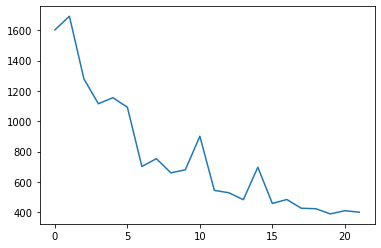

In [16]:
# loss plot
plt.plot(range(n_iterations), loss_list)
plt.show()

In [17]:
# Save model
nlp.meta['name'] = selected_region

art_path = os.path.dirname(os.getcwd()) + '/artifacts/'+selected_region
nlp.to_disk(art_path)
print("Saved model to", art_path)

Saved model to /home/ec2-user/SageMaker/ons-poc-manobras-catalog/artifacts/cosr-s


## Loading trained model

In [18]:
art_path = os.path.dirname(os.getcwd()) + '/artifacts/'+selected_region
saved_model = spacy.load(art_path)
saved_model

In [19]:
# running entity recognition in dataset
recognition_dict = {
    'entity':[],
    'type':[]
}

doc = saved_model('3.4.2.1. SE Teste Desenergização da LT 230 kV Ariquemes / Ji-Paraná C4 (Sentido Normal)PassoCoordenaçãoControleComando /ExecuçãoProcedimentoObjetivo / Item de Controle1COSR-NCOCOSR-NCOARGOAbrir o terminal da LT 230 kV Ariquemes / Ji-Paraná C4, na SE Ji-Paraná.'.lower())
for i in range(len(doc.ents)):
    recognition_dict['entity'].append(str(doc.ents[i]))
    recognition_dict['type'].append(doc.ents[i].label_)
    
recognition_dict

{'entity': ['se teste desenergização',
  'lt 230 kv ariquemes / ji-paraná c4',
  'sentido normal)passocoordenaçãocontrolecomando /execuçãoprocedimentoobjetivo / item de',
  'terminal',
  'lt 230 kv ariquemes / ji-paraná c4',
  'se ji-paraná'],
 'type': ['ESTADO_OPERATIVO',
  'EQUIPAMENTO',
  'EQUIPAMENTO',
  'ACAO_A_EXECUTAR',
  'EQUIPAMENTO',
  'SUBESTACAO']}

In [20]:
recognition_df = pd.DataFrame(recognition_dict)
recognition_df

,entity,type
0,se teste desenergização,ESTADO_OPERATIVO
1,lt 230 kv ariquemes / ji-paraná c4,EQUIPAMENTO
2,sentido normal)passocoordenaçãocontrolecomando...,EQUIPAMENTO
3,terminal,ACAO_A_EXECUTAR
4,lt 230 kv ariquemes / ji-paraná c4,EQUIPAMENTO
5,se ji-paraná,SUBESTACAO


## Entity Recognition with custom model 

In [21]:
bucket = 'ons-dl-dev-landing'
prefix = 'ons/mpo_ds_nlp/regioes-newjob/'+selected_region+'/samples.csv'
input_uri = 's3://{}/{}'.format(bucket, prefix)

# reading samples from s3
sample = wr.s3.read_csv(input_uri)

# the first row has to be extracted from the column name 
# as the csv file has no header
extra_sample = pd.DataFrame(columns=['samples'])
extra_sample['samples'] = [sample.columns[0]]
sample.columns = ['samples']
sample = pd.concat([extra_sample, sample], axis=0)
sample.reset_index(inplace=True,drop=True)
sample.columns=['samples']
sample['samples'] = sample['samples'].str.lower()
sample.head()

,samples
0,passocoordenaçãocontrolecomando / execuçãoproc...
1,3.1.2.1. energização da lt 440 kv ilha solteir...
2,passocoordenaçãocontrolecomando / execuçãoproc...
3,3.10.2.1. energização da l...
4,passocoordenaçãocontrolecomando / execuçãoproc...


In [22]:
preproc = preprocess_data()

# reading file contents from s3 bucket
df_raw = preproc.get_baseline_text()
df_raw['texto'] = df_raw['texto'].str.lower()
df_raw.head()

sample['equipment'] = None
unique_txt = list(set(sample['samples']))

for text in unique_txt:
    df_map = df_raw[df_raw['texto'] == text]
    df_aux = sample[sample['samples'] == text]
    index_list = list(df_aux.index)
    sample['equipment'].iloc[index_list] = str(df_map['MpoEquipamentos'].values[0])

sample

Preprocessing module
started at  2021-11-04 15:51:48.627134


,samples,equipment
0,passocoordenaçãocontrolecomando / execuçãoproc...,"LT 440 kV Ilha Solteira / Ilha Solteira 2 C1, ..."
1,3.1.2.1. energização da lt 440 kv ilha solteir...,"LT 440 kV Ilha Solteira / Ilha Solteira 2 C1, ..."
2,passocoordenaçãocontrolecomando / execuçãoproc...,LT 230 kV Campo Grande 2 / Rio Brilhante
3,3.10.2.1. energização da l...,LT 230 kV Campo Grande 2 / Rio Brilhante
4,passocoordenaçãocontrolecomando / execuçãoproc...,LT 230 kV Dourados / Ivinhema 2
...,...,...
744,4.82.2.1. energização do transformador tr-2 23...,SE Venâncio Aires – Transformador TR-1 230/69/...
745,passocoordenaçãocontrolecomando e execuçãoproc...,UHE Passo Real – Transformador AT-1 230/138/13...
746,4.84.2.1. energização do transformador at-1 23...,UHE Passo Real – Transformador AT-1 230/138/13...
747,passocoordenaçãocontrolecomando e execuçãoproc...,UHE Passo Real – Transformador AT-1 230/138/13...


In [23]:
# running entity recognition in dataset
recognition_dict = {
    'text':[],
    'entity':[],
    'type':[],
    'equipment':[]
}

for index, samp in sample.iterrows():
    doc = saved_model(samp['samples'])
    local_entity_list = []
    local_label_list = []
    for i in range(len(doc.ents)):
        local_entity_list.append(str(doc.ents[i]))
        local_label_list.append(doc.ents[i].label_)
    recognition_dict['text'].append(samp['samples'])
    recognition_dict['entity'].append(local_entity_list)
    recognition_dict['type'].append(local_label_list)
    recognition_dict['equipment'].append(samp['equipment'])

recognition_df = pd.DataFrame(recognition_dict)
    
bucket = 'ons-dl-dev-landing'
prefix = 'ons/mpo_ds_nlp/data/postprocessed_output/spacy/samples/entities-'+selected_region+'.parquet'
output_uri = 's3://{}/{}'.format(bucket, prefix)

recognition_df.to_parquet(output_uri)
print('Saved output file in ', output_uri)

Saved output file in  s3://ons-dl-dev-landing/ons/mpo_ds_nlp/data/postprocessed_output/spacy/samples/entities-cosr-s.parquet


In [24]:
preproc = preprocess_data()

# breaking into sentences
output_dataset = preproc.get_split_entity_sequence(
        dataset=sample,
        column='samples'
        )

# running entity recognition in dataset
recognition_dict = {
    'text':[],
    'entity':[],
    'type':[],
    'equipment':[]
}

for index, samp in output_dataset.iterrows():
    doc = saved_model(samp['samples'])
    local_entity_list = []
    local_label_list = []
    for i in range(len(doc.ents)):
        local_entity_list.append(str(doc.ents[i]))
        local_label_list.append(doc.ents[i].label_)
    recognition_dict['text'].append(samp['samples'])
    recognition_dict['entity'].append(local_entity_list)
    recognition_dict['type'].append(local_label_list)
    recognition_dict['equipment'].append(samp['equipment'])

recognition_df = pd.DataFrame(recognition_dict)
recognition_df = recognition_df[recognition_df['entity'].map(lambda i: len(i)) > 0]
recognition_df.reset_index(drop=True, inplace=True)

bucket = 'ons-dl-dev-landing'
prefix = 'ons/mpo_ds_nlp/data/postprocessed_output/spacy/sentences/entities-'+selected_region+'.parquet'
output_uri = 's3://{}/{}'.format(bucket, prefix)

recognition_df.to_parquet(output_uri)
print('Saved output file in ', output_uri)

Preprocessing module
started at  2021-11-04 15:53:50.882735
Saved output file in  s3://ons-dl-dev-landing/ons/mpo_ds_nlp/data/postprocessed_output/spacy/sentences/entities-cosr-s.parquet


In [25]:
n=5
for i in range(len(recognition_df['entity'].iloc[n])):
    print(recognition_df['entity'].iloc[n][i], '->', recognition_df['type'].iloc[n][i])

nas demais situações o fechamento dos disjuntores será coordenado pelo cosr-se -> ESTADO_OPERATIVO
em anel ou energizando o barramento de 440 kv -> ACAO_A_EXECUTAR
lt 440 kv ilha solteira / ilha solteira 2 c1 (ou c2 -> EQUIPAMENTO
se ilha solteira 2 -> SUBESTACAO
